In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install Flask
!pip install category_encoders
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095435 sha256=a47646024c68054fd8a07d18079772ed3e107eb4195bffd16f4569dfbedafe84
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
import pandas as pd
import math
import numpy as np
import seaborn as sns


# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# for model selection
# pip install scikit-surprise
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, SlopeOne, NMF, NormalPredictor,BaselineOnly, CoClustering
from surprise import accuracy

# for app.py
from flask import Flask, request, jsonify
app = Flask(__name__)

# Preprocessing and model training code here

@app.route('/predict', methods=['POST'])
def predict():
    # Get input data from the request
    input_data = request.get_json()
    
    # Validate input data, preprocess and calculate cluster points
    
    # Use the model to predict and recommend courses
    
    # Return cluster points and recommended courses
    return jsonify({'cluster_points': cluster_points, 'recommended_courses': recommended_courses})

# if __name__ == '__main__':
#     app.run()

In [5]:
student = pd.read_csv('/content/drive/MyDrive/DATASETS/ClassifyMe/students_data.csv')
courses = pd.read_csv('/content/drive/MyDrive/DATASETS/ClassifyMe/course_catalogue.csv')
historical = pd.read_csv('/content/drive/MyDrive/DATASETS/ClassifyMe/historical_data.csv')


In [6]:
student.sample(5)

,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall Grade,Interest
640,S641,Cook,Wilson,1,6,2,9,9,12,61,Pharmacy
163,S164,Lewis,Layla,9,3,6,6,10,11,78,Medical Research
707,S708,Rodriguez,Emma,5,2,11,6,4,12,71,Pharmacy
305,S306,Leah,King,4,5,2,8,11,9,66,Pharmacy
150,S151,Addison,Luna,5,10,8,11,6,1,72,Public Health


In [7]:
student.shape

(1000, 11)

# Data Cleaning

In [8]:
student.columns = student.columns.str.replace(' ', '_')
historical.columns = historical.columns.str.replace(' ', '_')

In [9]:
def lang(student):
  if student['English'] >= student['Kiswahili']:
    return student['English']
  else:
    return student['Kiswahili']
    

def science(student):
  if student['Mathematics'] >= student['Physics']:
    return student['Mathematics']
  else:
    return student['Physics']
  



In [10]:
student['languages'] = student.apply(lang, axis=1)
student['science'] = student.apply(science, axis=1)
student

,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall_Grade,Interest,languages,science
0,S001,Chloe,Jackson,6,7,1,6,1,12,78,Pharmacy,7,6
1,S002,Layla,Rodriguez,12,9,5,6,4,4,81,Nursing,12,6
2,S003,Cooper,Wright,6,6,4,10,10,2,56,Pharmacy,6,10
3,S004,Wilson,Abigail,3,5,4,2,7,11,54,Surgery,5,4
4,S005,Addison,King,4,8,6,7,3,4,56,Medical Research,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S996,Harris,Cook,10,7,1,2,2,11,55,Surgery,10,2
996,S997,Stella,Sofia,3,5,2,11,2,3,74,Therapy,5,11
997,S998,Parker,Penelope,10,3,5,2,10,1,60,Pharmacy,10,5
998,S999,Hazel,Lopez,8,11,5,9,7,10,69,Therapy,11,9


In [11]:
core_subjects = ['languages', 'science','Biology', 'Chemistry']
student['points'] = student[core_subjects].sum(axis=1)
student

,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall_Grade,Interest,languages,science,points
0,S001,Chloe,Jackson,6,7,1,6,1,12,78,Pharmacy,7,6,26
1,S002,Layla,Rodriguez,12,9,5,6,4,4,81,Nursing,12,6,26
2,S003,Cooper,Wright,6,6,4,10,10,2,56,Pharmacy,6,10,28
3,S004,Wilson,Abigail,3,5,4,2,7,11,54,Surgery,5,4,27
4,S005,Addison,King,4,8,6,7,3,4,56,Medical Research,8,7,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S996,Harris,Cook,10,7,1,2,2,11,55,Surgery,10,2,25
996,S997,Stella,Sofia,3,5,2,11,2,3,74,Therapy,5,11,21
997,S998,Parker,Penelope,10,3,5,2,10,1,60,Pharmacy,10,5,26
998,S999,Hazel,Lopez,8,11,5,9,7,10,69,Therapy,11,9,37


In [12]:
def cluster_points(student):
  mult = (student['points']/48)*(student['Overall_Grade']/84)
  cluster = 48 * math.sqrt(mult)
  return cluster

In [13]:
student['cluster_points'] = student.apply(cluster_points,axis=1)
student

,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall_Grade,Interest,languages,science,points,cluster_points
0,S001,Chloe,Jackson,6,7,1,6,1,12,78,Pharmacy,7,6,26,34.041991
1,S002,Layla,Rodriguez,12,9,5,6,4,4,81,Nursing,12,6,26,34.690468
2,S003,Cooper,Wright,6,6,4,10,10,2,56,Pharmacy,6,10,28,29.933259
3,S004,Wilson,Abigail,3,5,4,2,7,11,54,Surgery,5,4,27,28.864214
4,S005,Addison,King,4,8,6,7,3,4,56,Medical Research,8,7,22,26.532998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S996,Harris,Cook,10,7,1,2,2,11,55,Surgery,10,2,25,28.030596
996,S997,Stella,Sofia,3,5,2,11,2,3,74,Therapy,5,11,21,29.799329
997,S998,Parker,Penelope,10,3,5,2,10,1,60,Pharmacy,10,5,26,29.856801
998,S999,Hazel,Lopez,8,11,5,9,7,10,69,Therapy,11,9,37,38.194988


# Courses

In [14]:
courses.sample(5)

,Course_name,Description,Keywords,Core_units,Reviews,Weighted_points,Job_satisfaction
11,Radiography,This course focuses on the use of imaging tech...,"medical imaging, radiology","Anatomy and Physiology, Medical Imaging Techni...",4.6,38.65,4.7
10,Clinical Medicine and Surgery,This course focuses on the study and treatment...,"human diseases, medical procedures","Anatomy and Physiology, Pharmacology, Surgical...",4.7,44.74,4.8
23,Reproductive Health,This course covers reproductive health and the...,"reproductive health, reproductive disorders, f...","Reproductive Anatomy and Physiology, Family Pl...",4.2,37.89,4.3
3,Medical Laboratory Sciences,This course trains students to become medical ...,"Medical Laboratory, Diagnostics, Health","Medical Microbiology, Hematology, Clinical Che...",4.5,37.89,4.5
12,Optometry,This course focuses on the diagnosis and treat...,"vision problems, optometry","Ophthalmic Optics, Visual Perception, Optometr...",4.9,40.08,4.9


In [15]:
courses.describe()

,Reviews,Weighted_points,Job_satisfaction
count,30.000000,30.000000,30.000000
mean,4.470000,38.328000,4.600000
std,0.233637,2.757507,0.257307
min,4.000000,32.750000,4.000000
25%,4.300000,36.840000,4.500000
50%,4.450000,38.505000,4.600000
75%,4.675000,39.522500,4.800000
max,4.900000,44.740000,5.000000


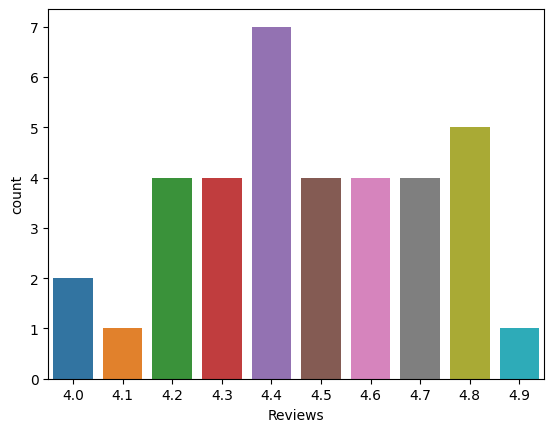

In [16]:
sns.countplot(x=courses['Job_satisfaction']);
sns.countplot(x=courses['Reviews']);

In [17]:
historical.sample(5)

,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall_Grade,Interest,Cluster_Points,Course
638,S639,Gonzalez,Addison,6,6,9,10,10,7,62,Surgery,34.193,Not elligible
139,S140,Ava,Scott,10,11,10,7,6,8,67,Laboratories,36.606,Medical Illustration and Animation
38,S039,Davis,Scott,11,9,10,11,10,8,62,Surgery,37.645,Not elligible
816,S817,Reed,Moore,9,12,9,11,10,7,70,Pharmacy,40.000,Not elligible
160,S161,Wright,Sofia,8,11,9,10,6,11,68,Laboratories,38.426,Medical Biotechnology


In [18]:
merged_df = pd.merge(historical, courses[['Course_name', 'Weighted_points', 'Job_satisfaction',  'Description', 'Keywords' ]],
                     left_on='Course', right_on='Course_name', how='left')
merged_df = merged_df.drop(['Course_name'], axis=1)
merged_df.sample(5)


,ID,First_Name,Last_Name,English,Kiswahili,Mathematics,Physics,Biology,Chemistry,Overall_Grade,Interest,Cluster_Points,Course,Weighted_points,Job_satisfaction,Description,Keywords
89,S090,Hazel,Ellie,6,11,11,9,10,7,63,Surgery,37.470,Not elligible,NaN,NaN,NaN,NaN
784,S785,Campbell,Zoey,7,9,11,10,10,11,82,Nursing,43.831,Nursing,39.47,4.0,This course trains students to become register...,"Anatomy, Physiology, Medical-Surgical Nursing"
595,S596,Claire,Brooklyn,9,12,11,7,9,12,73,Medical Research,42.842,Epidemiology and Biostatistics,37.10,4.6,This course focuses on the study of the distri...,"epidemiology, biostatistics, public health, po..."
224,S225,Moore,Anderson,9,11,10,9,8,8,80,Public Health,41.127,Health Records and Information Technology,33.89,4.5,This course focuses on the management of patie...,"health records, healthcare technology"
718,S719,Aubrey,Emily,12,6,7,11,8,10,66,Laboratories,39.323,Medical Illustration and Animation,35.00,4.8,This course covers the use of illustration and...,"medical illustration, medical animation, scien..."


In [19]:
merged_df['Course'].value_counts()

Not elligible                                326
Palliative Care and Hospice Services         118
Medical Illustration and Animation            45
Nutrition and Dietetics                       43
Epidemiology and Biostatistics                40
Health Education and Promotion                37
Clinical Research                             37
Nursing                                       34
Health Records and Information Technology     29
Public Health                                 27
Medical Biotechnology                         26
Pharmacy                                      25
Environmental Health                          21
Medical Physics                               20
Health Systems Management                     17
Clinical Psychology                           16
Medical Laboratory Sciences                   15
Forensic Science                              15
Medical Anthropology                          14
Radiography                                   14
Medical Imaging Scie

In [20]:
df = merged_df.loc[merged_df['Course'] != 'Not elligible']
df.shape

(674, 17)

In [21]:
# Define the filter condition based on Cluster Points and Weighted_points and Filter the dataset
filtered_df = df.loc[df['Cluster_Points'] <= df['Weighted_points']]
filtered_df.shape

(0, 17)

#Feature Engineering

In [22]:
df1= df.copy()

In [23]:
df1['Interest'].unique()

array(['Public Health', 'Laboratories', 'Nursing', 'Medical Research',
       'Therapy', 'Pharmacy', 'Surgery'], dtype=object)

In [24]:

from category_encoders import OrdinalEncoder
mapping = [{'col': 'Interest', 'mapping': {'Public Health': 1,  'Laboratories': 2,
                                         'Nursing': 3, 'Medical Research': 4,
                                         'Therapy': 5, 'Pharmacy': 5, 'Surgery': 6}}]
# Create an OrdinalEncoder object and fit it to the DataFrame
encoder = OrdinalEncoder(cols=['Interest'], mapping=mapping)
encoder.fit(df1)

# Transform the DataFrame using the fitted encoder
df_encoded = encoder.transform(df1)

## Model Selection

In [25]:
reader = Reader(rating_scale=(4.0, 5.0))
data   = Dataset.load_from_df(df_encoded[['ID','Interest','Job_satisfaction']], reader)

raw_ratings = data.raw_ratings

import random
random.shuffle(raw_ratings)                 # shuffle dataset

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold] # 80% of data is trainset
test_raw_ratings  = raw_ratings[threshold:] # 20% of data is testset

data.raw_ratings = train_raw_ratings        # data is now the trainset
trainset         = data.build_full_trainset() 
testset          = data.construct_testset(test_raw_ratings)


In [26]:
models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline(),SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), BaselineOnly(), CoClustering()] 
results = {}

for model in models:
    # perform 5 fold cross validation
    # evaluation metrics: mean absolute error & root mean square error
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    
    # storing the average score across the 5 fold cross validation for each model
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

In [27]:
performance_df = pd.DataFrame.from_dict(results)
print("Model Performance: \n")
performance_df.T.sort_values(by='RMSE')

Model Performance: 



,MAE,RMSE,fit_time,test_time
baseline_only.BaselineOnly,0.180037,0.226071,0.001793,0.000624
matrix_factorization.SVD,0.180650,0.226207,0.010360,0.000679
knns.KNNBaseline,0.180100,0.226654,0.007004,0.000852
matrix_factorization.SVDpp,0.177596,0.228711,0.007517,0.000729
slope_one.SlopeOne,0.184063,0.251218,0.007646,0.000977
knns.KNNWithMeans,0.183922,0.251428,0.016030,0.002918
matrix_factorization.NMF,0.183861,0.251789,0.050800,0.000748
knns.KNNWithZScore,0.183781,0.251913,0.039099,0.001103
knns.KNNBasic,0.183765,0.252113,0.004999,0.001079
co_clustering.CoClustering,0.183882,0.252233,0.069603,0.000606


-  **KNNWithMeans**, **KNNWithZScore** and **KNNBaseline** has the least MAE and RMSE but **KNNWithMeans** has the least test time among them.



## Hyperparameter Tuning

In [28]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'k': [10, 20, 30, 40, 50],
              'sim_options': {'name': ['cosine', 'msd', 'pearson'],\
                              'min_support': [10,12], \
                                'user_based': [False, True]}
              }


gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)
                                    
gridsearchKNNWithMeans.fit(data)

print(f'MAE Best Parameters:  {gridsearchKNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchKNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchKNNWithMeans.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchKNNWithMeans.best_score["rmse"]}\n')

MAE Best Parameters:  {'k': 10, 'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': False}}
MAE Best Score:       0.1842533252781371

RMSE Best Parameters: {'k': 10, 'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': False}}
RMSE Best Score:      0.2523089619842208



In [29]:
# Model fit & prediction - KNNWithMeans
k=10
sim_options = {'name':'cosine','min_support':10,'user_based':True}
final_model = KNNWithMeans(k=k,sim_options=sim_options)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance:')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

Computing the cosine similarity matrix...
Done computing similarity matrix.

Unbiased Testing Performance:
MAE:  0.1944
RMSE: 0.2645
MAE: 0.19436404864976287, RMSE: 0.2644727369911912


The parameters:'k': 10, 'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': True are selected as they give the best RMSE and MAE scores.



# Building the recommendation system

In [30]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(4.0, 5.0))
data = Dataset.load_from_df(df_encoded[['ID','Interest','Job_satisfaction']], reader=reader)
trainset = data.build_full_trainset()

In [31]:
def get_course_recommendations(trainset, user_id):
    k = 10
    sim_options = {'name':'cosine', 'min_support':10, 'user_based':False}
    # Create an instance of the KNNWithMeans algorithm with the given hyperparameters
    algo = KNNWithMeans(k=k, sim_options=sim_options)

    # fit the algorithm to the training set
    algo.fit(trainset)

    # get the inner user id
    inner_user_id = trainset.to_inner_uid(user_id)

    # get the courses the user has already rated
    rated_courses = set([r[0] for r in trainset.ur[inner_user_id]])

    # get all courses
    course_ids = [iid for iid in trainset.all_items()]

    # Get the list of courses the user is interested in
    user_interests = df_encoded.loc[df_encoded['ID'] == user_id, 'Interest'].unique()
    print(f'User Interest: {user_interests} ')

    # # Create a list of tuples of (course, predicted rating) for each course
    course_ratings = []
    for course in df_encoded.loc[df_encoded['Interest'].isin(user_interests), 'Course'].unique():
      if course not in rated_courses:
        predicted_rating = algo.predict(uid=user_id, iid=course).est
        course_ratings.append((course, predicted_rating))

    # Sort the list of course ratings by predicted rating
    course_ratings_sorted = sorted(course_ratings, key=lambda x: x[1], reverse=True)

    print(course_ratings_sorted)

    # Create a list of the top three recommended courses that match the user's interests
    recommended_courses = []
    for course_rating in course_ratings_sorted:
      if course_rating[0] not in user_interests:
        recommended_courses.append(course_rating[0])
        if len(recommended_courses) == 3:
            break
    return recommended_courses

In [32]:
user_id = 'S468'
recommended_courses = get_course_recommendations(trainset, user_id)
print(recommended_courses)

Computing the cosine similarity matrix...
Done computing similarity matrix.
User Interest: [5] 
[('Clinical Psychology', 4.546142433234421), ('Nutrition and Dietetics', 4.546142433234421), ('Pharmacy', 4.546142433234421), ('Radiography', 4.546142433234421), ('Orthotics and Prosthetics', 4.546142433234421), ('Speech Therapy', 4.546142433234421), ('Occupational Therapy', 4.546142433234421), ('Optometry', 4.546142433234421), ('Physiotherapy', 4.546142433234421)]
['Clinical Psychology', 'Nutrition and Dietetics', 'Pharmacy']


In [33]:
import pickle
import gzip
import os


# Save the trained model using pickle
with gzip.open('KNNWithMeans_pickled_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

os.listdir('.')

['.config',
 'KNNWithMeans_pickled_model.pklz',
 'drive',
 'KNNWithMeans_pickled_model.pkl',
 'sample_data']